In [0]:
# Import libraries
import numpy as np
from statsmodels.tsa.arima_process import ArmaProcess, arma_generate_sample

def get_windowed_data(data, window_size=50, forward_look=1):
    '''
    Turns a 1D time series into a set of features of size window_size and
    a set of targets of size forward_look

    Parameters
    ----------
    data : Numpy array
        Time series to convert
    window_size : Integer, optional
        Length of build-up period to be used as features. The default is 50.
    forward_look : Integer, optional
        Desired forecasting distance. The default is 1.

    Returns
    -------
    features : Numpy array
        Build-up periods for each forecasting interval.
    outputs : Numpy array
        Target forecasting intervals.
    '''

    n_obs = data.shape[0] # Get number of observations 
    new_n_obs = n_obs - forward_look - window_size + 1 # Adjust n_obs
    
    # Create arrays of 0's to be overwritten
    features = np.zeros((new_n_obs, window_size))
    outputs = np.zeros((new_n_obs, forward_look))
    
    # Fill in arrays
    for t in range(new_n_obs):
        features[t,:] = data[t:(t + window_size)]
        outputs[t,:] = data[(t + window_size):(t + window_size + forward_look)]
        
    return features, outputs 

# Generating simulated data
np.random.seed(17) # Set seed

k = 0
while k < 1:
    # Generate normal parameters
    ar_params = np.random.randn(3)
    ma_params = np.random.randn(3)
    ar = np.r_[1, -ar_params] # add zero-lag and negate
    ma = np.r_[1, ma_params] # add zero-lag
    # Check for stationarity, invertibility
    arma = ArmaProcess(ar, ma)
    if not (arma.isstationary and arma.isinvertible):
        continue
    data = arma_generate_sample(ar, ma, 1000, burnin=10) # Accept if invertible
    k += 1

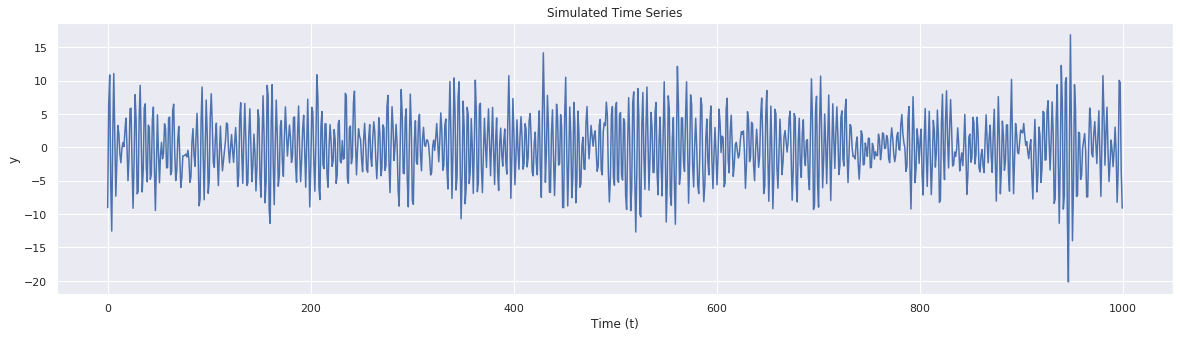

In [2]:
# Import libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Plot simulated data
sns.set()
plt.rcParams['figure.figsize'] = [20, 5] # Set default figure size
plt.title('Simulated Time Series')
plt.xlabel('Time (t)')
plt.ylabel('y')
plt.plot(data)
plt.show()

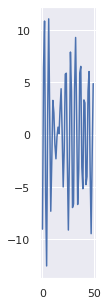

In [3]:
X, y = get_windowed_data(data) # Turn series into features, outputs

# Plot example features
plt.rcParams['figure.figsize'] = [1, 5]
plt.plot(X[0])
plt.show()

In [0]:
from sklearn.model_selection import train_test_split # Import library

# Reshape for RNN: (number of samples, number of time steps, number of total covariates)
X = X.reshape(X.shape[0], X.shape[1], 1) 
# Split into train, test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=17, shuffle=False)


In [5]:
# Import libraries
import tensorflow as tf
from tensorflow.keras import layers

# Model architecture
rnn = tf.keras.Sequential()
rnn.add(layers.SimpleRNN(50, activation='relu'))
rnn.add(layers.Dense(1))

# Compile and fit
rnn.compile(loss='mse', optimizer='sgd')
rnn.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1, shuffle=False)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 760 samples
Epoch 1/100
760/760 [==============================] - 1s 2ms/sample - loss: 7.4806
Epoch 2/100
760/760 [==============================] - 0s 472us/sample - loss: 2.9027
Epoch 3/100
760/760 [==============================] - 0s 390us/sample - loss: 2.7465
Epoch 4/100
760/760 [==============================] - 0s 385us/sample - loss: 2.5552
Epoch 5/100
760/760 [==============================] - 0s 421us/sample - loss: 2.7793
Epoch 6/100
760/760 [==============================] - 0s 390us/sample - loss: 2.3244
Epoch 7/100
760/760 [==============================] - 0s 438us/sample - loss: 2.4897
Epoch 8/100
760/760 [==============================] - 0s 404us/sample - loss: 2.4063
Epoch 9/100
760/760 [==============================] - 0s 433us/sample - loss: 2.3804
Epoch 10/100
760/760 [==============================] - 0s 416us/sample - loss: 2.2778
Epoch 11/100
760/760 [=================

In [6]:
rnn.summary() # Get model summary

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       multiple                  2600      
_________________________________________________________________
dense (Dense)                multiple                  51        
Total params: 2,651
Trainable params: 2,651
Non-trainable params: 0
_________________________________________________________________


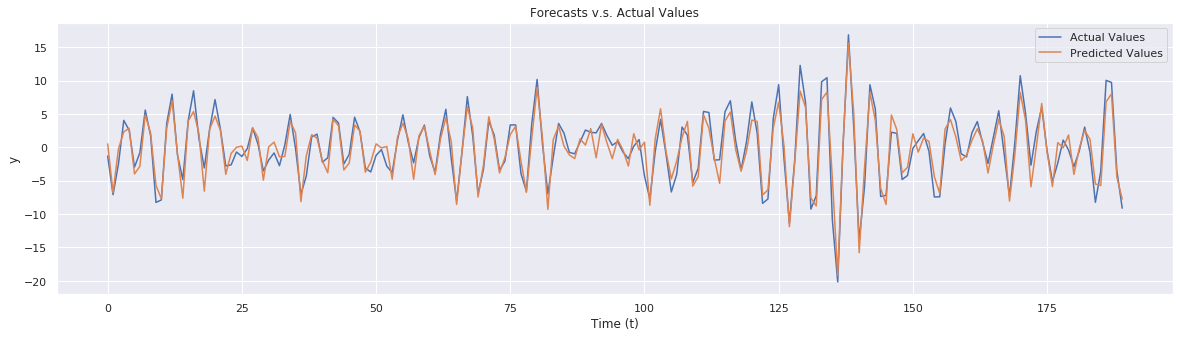

In [7]:
y_hat = rnn.predict(X_test) # Get forecast

# Plot forecast vs actual values
sns.set()
plt.rcParams['figure.figsize'] = [20, 5]
plt.title('Forecasts v.s. Actual Values')
plt.xlabel('Time (t)')
plt.ylabel('y')
plt.plot(y_test, label='Actual Values')
plt.plot(y_hat, label='Predicted Values')
plt.legend()
plt.show()

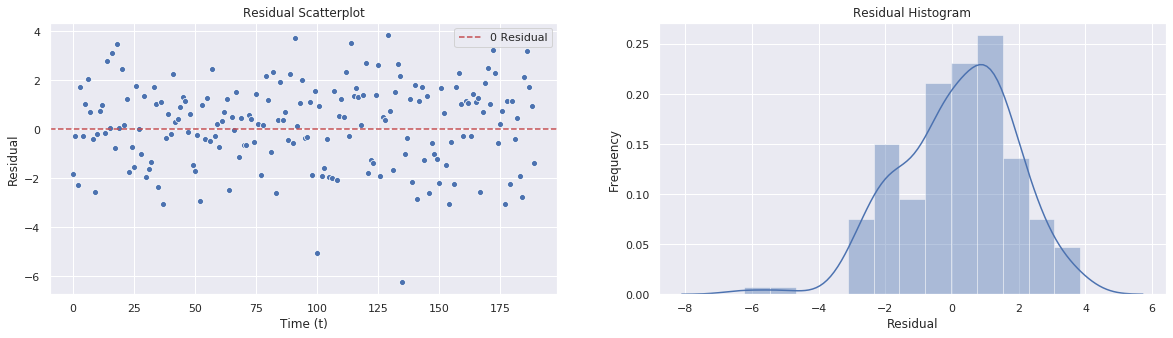

In [8]:
residuals = y_test - y_hat # Get residuals

# Residual diagnostic plots
sns.set()
fig, axs = plt.subplots(ncols=2)

x = np.arange(len(residuals))
sns.scatterplot(x, residuals.ravel(), ax=axs[0])
axs[0].axhline(color='r', ls='--', label='0 Residual')
axs[0].set_xlabel('Time (t)')
axs[0].set_ylabel('Residual')
axs[0].set_title('Residual Scatterplot')
axs[0].legend()

sns.distplot(residuals, ax=axs[1])
axs[1].set_xlabel('Residual')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Residual Histogram')

plt.show()